# 2. PCA Analysis
Reducing dimensionality of binary board game features and visualize PCA space.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Set display options and styling
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

# Create output directory for plots if it doesn't exist
import os
if not os.path.exists('../plots'):
    os.makedirs('../plots')
if not os.path.exists('../frames'):
    os.makedirs('../frames')

In [8]:
# Load processed data
filtered_df = pd.read_csv('../frames/filtered_games.csv')
all_binary_cols = np.load('../frames/all_binary_cols.npy', allow_pickle=True)

print(f"Loaded {len(filtered_df)} games with {len(all_binary_cols)} binary features")

Loaded 12239 games with 392 binary features


# Finding Optimal Components

Applying PCA...


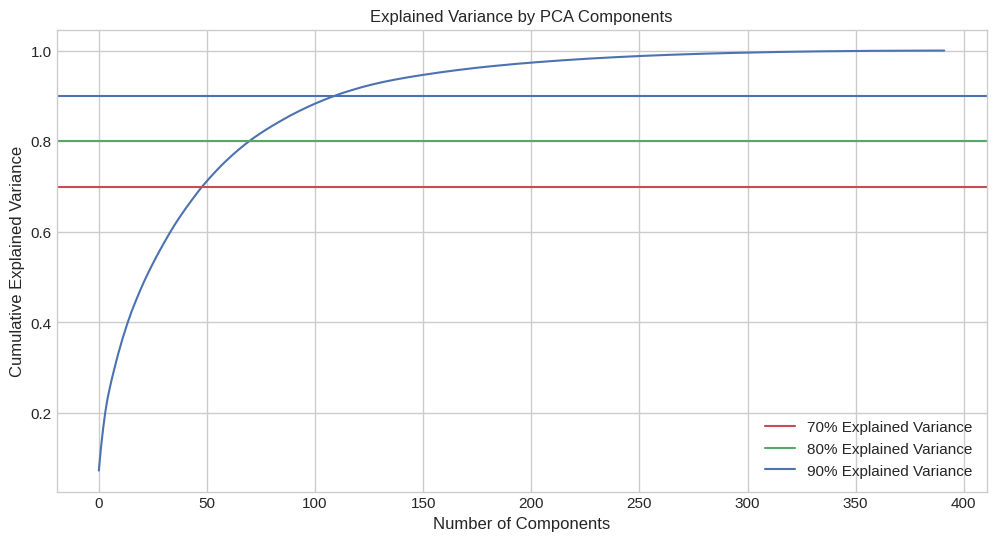

Number of components for 80% variance: 71
Number of components for 90% variance: 110


In [9]:
# Apply PCA to reduce dimensionality
print("Applying PCA...")
# Select only the binary features for PCA
feature_df = filtered_df[all_binary_cols].copy()

# Check for any remaining NaN values
nan_count = feature_df.isna().sum().sum()
if nan_count > 0:
    print(f"Found {nan_count} NaN values. Filling with 0...")
    feature_df = feature_df.fillna(0)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(feature_df)

# Plot explained variance
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.7, color='r', linestyle='-', label='70% Explained Variance')
plt.axhline(y=0.8, color='g', linestyle='-', label='80% Explained Variance')
plt.axhline(y=0.9, color='b', linestyle='-', label='90% Explained Variance')
plt.grid(True)
plt.legend()
plt.savefig('../plots/pca_explained_variance.png')
plt.show()
plt.close()

# Determine optimal number of components
n_components_80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1
n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of components for 80% variance: {n_components_80}")
print(f"Number of components for 90% variance: {n_components_90}")

# Analyze Final PCA Output

In [4]:
# Choose a balance between variance explained and number of components
n_components = n_components_80
print(f"\nUsing {n_components} components for further analysis")

# Apply PCA with selected number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(feature_df)

# Create a dataframe with PCA results
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# Add relevant information from the original dataset
pca_df['BGGId'] = filtered_df['BGGId'].values
pca_df['Name'] = filtered_df['Name'].values
pca_df['AvgRating'] = filtered_df['AvgRating'].values
pca_df['Year'] = filtered_df['YearPublished'].values
pca_df['NumUserRatings'] = filtered_df['NumUserRatings'].values
pca_df['Rating_Bracket'] = filtered_df['Rating_Bracket'].values

# Check PCA explained variance in more detail
print("\nIndividual explained variance per component:")
for i, var in enumerate(pca.explained_variance_ratio_[:20]):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")

# Examine feature importance in first few principal components
print("\nTop features in first few principal components:")
for i in range(min(5, n_components)):
    component = pd.Series(
        pca.components_[i],
        index=all_binary_cols
    )
    # Get top positive and negative contributors
    top_pos = component.nlargest(5)
    top_neg = component.nsmallest(5)
    
    print(f"\nPC{i+1} Top Positive Contributors:")
    for feat, val in top_pos.items():
        print(f"  {feat}: {val:.4f}")
    
    print(f"PC{i+1} Top Negative Contributors:")
    for feat, val in top_neg.items():
        print(f"  {feat}: {val:.4f}")

# Find potential outliers
from scipy import stats
# Z-score for each PCA component
z_scores = pd.DataFrame()
for col in pca_df.columns[:n_components]:
    z_scores[col] = np.abs(stats.zscore(pca_df[col]))
# Games with extreme values
outliers = pca_df[(z_scores > 3).any(axis=1)]
print(f"\nNumber of potential outliers: {len(outliers)}")
print("Example outliers:")
print(outliers[['Name', 'AvgRating', 'NumUserRatings']].head())


Using 71 components for further analysis

Individual explained variance per component:
PC1: 0.0730 (7.30%)
PC2: 0.0507 (5.07%)
PC3: 0.0425 (4.25%)
PC4: 0.0360 (3.60%)
PC5: 0.0289 (2.89%)
PC6: 0.0229 (2.29%)
PC7: 0.0212 (2.12%)
PC8: 0.0194 (1.94%)
PC9: 0.0186 (1.86%)
PC10: 0.0184 (1.84%)
PC11: 0.0169 (1.69%)
PC12: 0.0163 (1.63%)
PC13: 0.0152 (1.52%)
PC14: 0.0149 (1.49%)
PC15: 0.0139 (1.39%)
PC16: 0.0136 (1.36%)
PC17: 0.0123 (1.23%)
PC18: 0.0119 (1.19%)
PC19: 0.0116 (1.16%)
PC20: 0.0114 (1.14%)

Top features in first few principal components:

PC1 Top Positive Contributors:
  Dice Rolling: 0.5029
  Cat:War: 0.3357
  Hexagon Grid: 0.2254
  Simulation: 0.2237
  Grid Movement: 0.1474
PC1 Top Negative Contributors:
  Card Game: -0.4640
  Hand Management: -0.3182
  Set Collection: -0.1835
  Cat:Family: -0.1637
  Drafting: -0.1209

PC2 Top Positive Contributors:
  Variable Player Powers: 0.4513
  Fantasy: 0.3554
  Hand Management: 0.3534
  Fighting: 0.2829
  Cat:Thematic: 0.2518
PC2 Top Negat

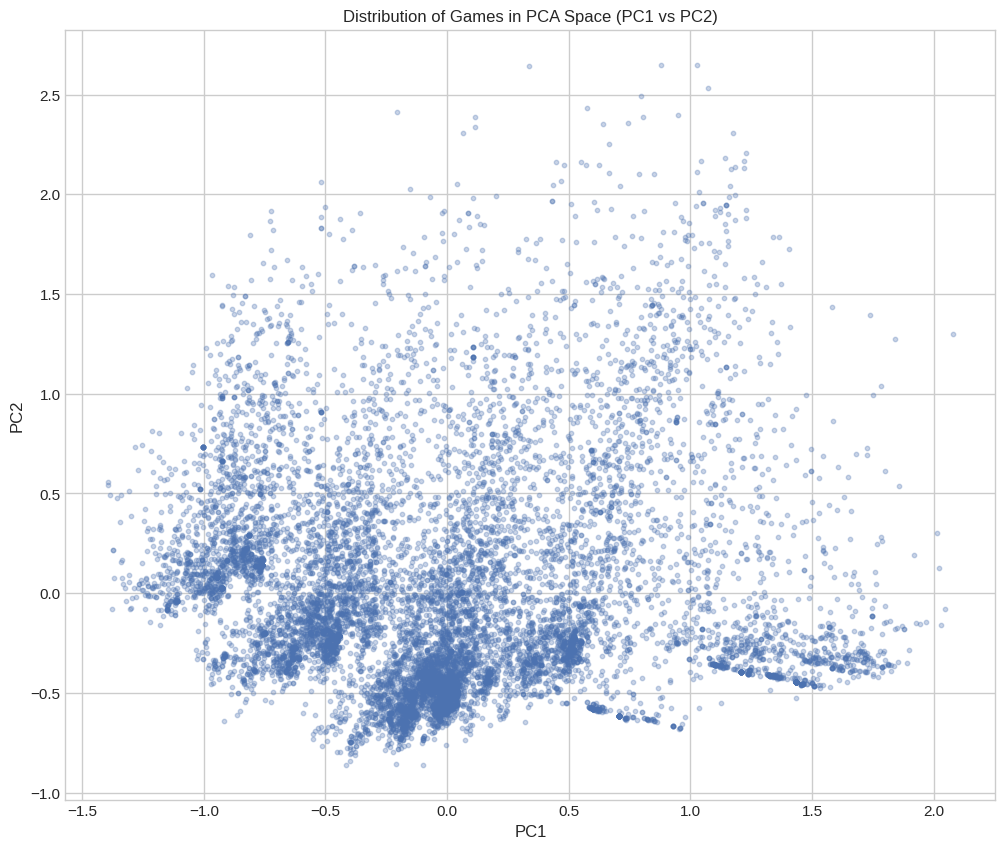

In [10]:
# Plot data distribution in PCA space
plt.figure(figsize=(12, 10))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.3, s=10)
plt.title('Distribution of Games in PCA Space (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.savefig('../plots/pca_distribution.png')
plt.show()
plt.close()

In [1]:
# Save PCA results for other notebooks
pca_df.to_csv('../frames/pca_results.csv', index=False)

NameError: name 'pca_df' is not defined